In [72]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
import pandas as pd

import pickle
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [4]:
BASELINE_MODEL = "weights/model_weights_1618972642.h5"

In [5]:
from data import load_ckplus
train_generator = load_ckplus("train")
test_generator = load_ckplus("test")

Found 924 images belonging to 8 classes.
Found 384 images belonging to 8 classes.


# Baseline

In [6]:
from fer_model import get_fer_model
model = get_fer_model()
model.load_weights(BASELINE_MODEL)

In [7]:
from evaluation import get_metrics
print("Baseline model performance:")
baseline_metrics = get_metrics(model, test_generator)
baseline_metrics

Baseline model performance:


{'size': 16512046,
 'acc': 0.6796875,
 'f_acc': 0.6708333333333333,
 'm_acc': 0.6944444444444444,
 'f_acc_breakdown': [0.5333333333333333,
  0.48484848484848486,
  1.0,
  0.7083333333333334,
  0.7142857142857143,
  0.9,
  0.2,
  0.8666666666666667],
 'f_acc_balanced': 0.6759334415584417,
 'm_acc_breakdown': [0.4166666666666667,
  0.4166666666666667,
  1.0,
  0.9523809523809523,
  0.0,
  0.75,
  0.3333333333333333,
  1.0],
 'm_acc_balanced': 0.6086309523809523}

# Pruning 

In [35]:
def get_samples(method, parameter): 
    logs = !ls logs
    if method == "pruning": 
        relevant_logs = list(filter(lambda x: ("pruned_model_metrics_s" + str(parameter)) in x, logs))
        
        all_metrics = []
        for log in relevant_logs: 
            file = open("logs/" + log,'rb')
            all_metrics.append(pickle.load(file))
            
        samples = {'size': [], 'acc': [], 'f_acc': [], 'm_acc': [], 'f_acc_balanced': [], 'm_acc_balanced': []}
        for metrics in all_metrics: 
            for key in samples: 
                samples[key].append(metrics[key])
                
        return samples
    if method == "clustering":
        relevant_logs = list(filter(lambda x: ("clustered_model_metrics_c" + str(parameter)) in x, logs))
        
        all_metrics = []
        for log in relevant_logs: 
            file = open("logs/" + log,'rb')
            all_metrics.append(pickle.load(file))
            
        samples = {'size': [], 'acc': [], 'f_acc': [], 'm_acc': [], 'f_acc_balanced': [], 'm_acc_balanced': []}
        for metrics in all_metrics: 
            for key in samples: 
                samples[key].append(metrics[key])
                
        return samples

In [36]:
def get_results_for(method, parameter): 
    samples = get_samples(method, parameter)

    return {
        "mean": {key: sum(samples[key])/len(samples[key]) for key in samples}, 
        "sd": {key: np.std(samples[key]) for key in samples}
    }

Model size


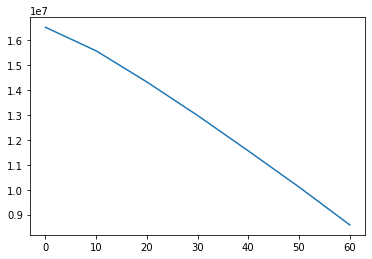

Modle accuracy


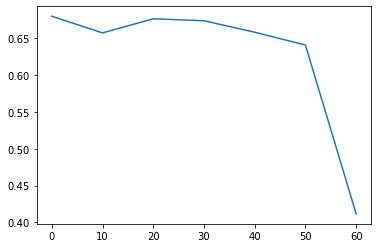

In [37]:
sparsities = [10, 20, 30, 40, 50, 60]
sizes = [] 
accs = []
for sp in sparsities: 
    results = get_results_for("pruning", sp)["mean"]
    sizes.append(results["size"])
    accs.append(results["acc"])
print("Model size")
plt.plot([0] + sparsities, [baseline_metrics["size"]] + sizes)
plt.show()
print("Modle accuracy")
plt.plot([0] + sparsities, [baseline_metrics["acc"]] + accs)

plt.show()

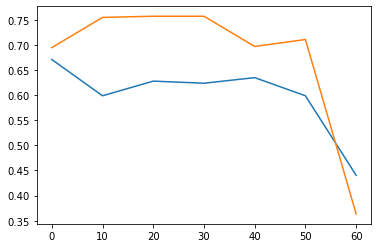

In [38]:
sparsities = [10, 20, 30, 40, 50, 60]
faccs = [] 
maccs = []
for sp in sparsities: 
    results = get_results_for("pruning", sp)["mean"]
    faccs.append(results["f_acc"])
    maccs.append(results["m_acc"])
plt.plot([0] + sparsities, [baseline_metrics["f_acc"]] + faccs)
plt.plot([0] + sparsities, [baseline_metrics["m_acc"]] + maccs)
plt.show()

# Clustering

Model size


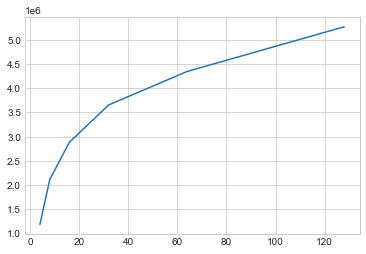

Model accuracy


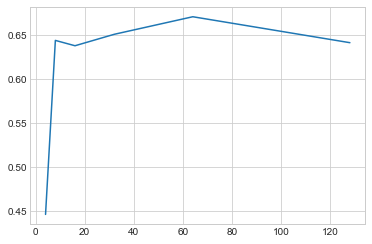

In [74]:
n_clusters = [4, 8, 16, 32, 64, 128]

print("Model size")
plt.plot(n_clusters, [get_results_for("clustering", n)["mean"]["size"] for n in n_clusters])
plt.show()

print("Model accuracy")
plt.plot(n_clusters, [get_results_for("clustering", n)["mean"]["acc"] for n in n_clusters])
plt.show()

In [86]:
acc_points = []
for n in n_clusters:
    acc_points += [(n, acc) for acc in (get_samples("clustering", n)["acc"])]

In [147]:
acc_means = np.array([get_results_for("clustering", n)["mean"]["acc"] for n in n_clusters])
acc_sds = np.array([get_results_for("clustering", n)["sd"]["acc"] for n in n_clusters])

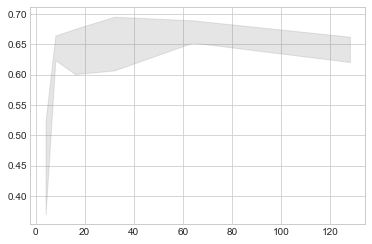

In [148]:
plt.fill_between(n_clusters, acc_means - acc_sds, acc_means + acc_sds,
                 color='gray', alpha=0.2)

In [113]:
np.polyfit(list(zip(*acc_points))[0], list(zip(*acc_points))[1], 2)

array([-2.82596150e-05,  4.42308879e-03,  5.32401982e-01])

In [123]:
x, y = list(zip(*acc_points))

In [124]:
x

(4, 4, 4, 8, 8, 8, 16, 16, 16, 32, 32, 32, 64, 64, 64, 128, 128, 128)

In [125]:
y

(0.5442708333333334,
 0.3567708333333333,
 0.4375,
 0.6197916666666666,
 0.6692708333333334,
 0.6432291666666666,
 0.59375,
 0.6354166666666666,
 0.6848958333333334,
 0.6796875,
 0.6848958333333334,
 0.5885416666666666,
 0.6510416666666666,
 0.6953125,
 0.6666666666666666,
 0.65625,
 0.6119791666666666,
 0.65625)

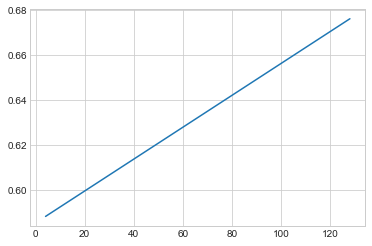

In [136]:
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))

In [171]:
import matplotlib.ticker as mtick

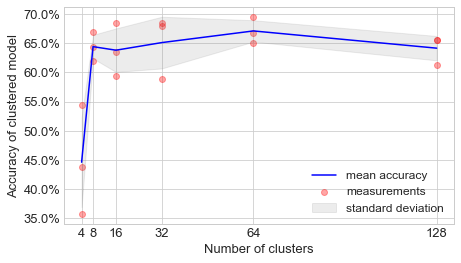

In [227]:
x, y = list(zip(*acc_points))

fig = plt.figure(1, (7,4))
ax = fig.add_subplot(1,1,1)

plt.tick_params(labelsize=13)

plt.scatter(x, y, c="red", alpha=0.35, label="measurements")
plt.plot(n_clusters, [get_results_for("clustering", n)["mean"]["acc"] for n in n_clusters], c="blue", label="mean accuracy")
plt.fill_between(n_clusters, acc_means - acc_sds, acc_means + acc_sds,
                 color='grey', alpha=0.15, label="standard deviation")
plt.xticks(n_clusters, n_clusters)
plt.xlabel("Number of clusters", size=13)
plt.ylabel("Accuracy of clustered model", size=13)

plt.legend(loc="lower right", prop={'size': 12})

yticks = mtick.PercentFormatter(1.0)
ax.yaxis.set_major_formatter(yticks)
plt.show()

In [ ]:
x, y = list(zip(*acc_points))

fig = plt.figure(1, (7,4))
ax = fig.add_subplot(1,1,1)

plt.tick_params(labelsize=13)

plt.scatter(x, y, c="red", alpha=0.35, label="measurements")
plt.plot(n_clusters, [get_results_for("clustering", n)["mean"]["acc"] for n in n_clusters], c="blue", label="mean accuracy")
plt.fill_between(n_clusters, acc_means - acc_sds, acc_means + acc_sds,
                 color='grey', alpha=0.15, label="standard deviation")
plt.xticks(n_clusters, n_clusters)
plt.xlabel("Number of clusters", size=13)
plt.ylabel("Accuracy of clustered model", size=13)

plt.legend(loc="lower right", prop={'size': 12})

yticks = mtick.PercentFormatter(1.0)
ax.yaxis.set_major_formatter(yticks)
plt.show()

In [162]:
x

(4, 4, 4, 8, 8, 8, 16, 16, 16, 32, 32, 32, 64, 64, 64, 128, 128, 128)